## Expedia hotel_cluster prediction

<p>Here is my suggestions on which features to use in out data leakage method (listed by importance from high to low):</p>
<li>'user_id'</li>
<li>'hotel_market'</li>
<li>'is_package'</li>
<li>'hotel_country'</li>

In [1]:
import pandas as pd
import pandas as np
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
import random
random.seed(1)

In [2]:
train = pd.read_csv('train.csv').sample(frac = 0.25)
test = pd.read_csv('test.csv').sample(frac = 0.25)

In [3]:
# split data_time column to year and month
train['date_time2'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time2'].dt.year
train['month'] = train['date_time2'].dt.month

# creat a column for total number cnt
train['srch_total_ppl_cnt'] = train['srch_children_cnt'] + train['srch_adults_cnt']


In [4]:
train.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster', u'date_time2',
       u'year', u'month', u'srch_total_ppl_cnt'],
      dtype='object')

In [5]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time2,year,month,srch_total_ppl_cnt
12551679,2013-12-15 16:29:26,37,1,69,761,41949,NaN,1186357,0,0,...,0,1,6,77,2,64,2013-12-15 16:29:26,2013,12,3
36961781,2014-10-02 15:11:24,2,3,66,311,38374,3606.5928,1063943,0,0,...,0,1,6,204,1772,78,2014-10-02 15:11:24,2014,10,2
4454551,2014-12-13 00:46:49,2,3,66,311,30031,186.4737,711580,0,0,...,0,1,2,50,675,56,2014-12-13 00:46:49,2014,12,2
27423373,2014-03-02 15:47:16,2,3,66,184,11878,741.3282,1039443,0,0,...,0,1,2,50,714,91,2014-03-02 15:47:16,2014,3,3
13226995,2013-11-13 15:59:50,2,3,66,258,4687,949.8963,1009736,0,0,...,0,1,2,50,409,75,2013-11-13 15:59:50,2013,11,2


In [6]:
test.columns

Index([u'id', u'date_time', u'site_name', u'posa_continent',
       u'user_location_country', u'user_location_region',
       u'user_location_city', u'orig_destination_distance', u'user_id',
       u'is_mobile', u'is_package', u'channel', u'srch_ci', u'srch_co',
       u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt',
       u'srch_destination_id', u'srch_destination_type_id', u'hotel_continent',
       u'hotel_country', u'hotel_market'],
      dtype='object')

Most of the features are categorical. I will check these categorical feature one by one and test which ones changes the distribution of 'hotel_cluster'. Due to time limitation, I will NOT conduct any statistic tests here. I just visually check the figures and make my judgement.

First, let's check 'posa_continent'.

In [7]:
# 
train['posa_continent'].value_counts()

3    7059978
1    1114603
2     878737
4     297850
0      66405
Name: posa_continent, dtype: int64

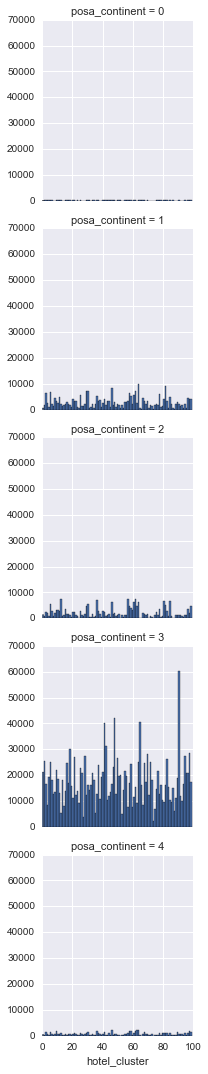

In [8]:
p = sns.FacetGrid(train.sample(frac = 0.25), row = 'posa_continent')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

Check 'user_location_country' next.

In [9]:
train['user_location_country'].value_counts().size

235

There are 236 different user_location_country. It is not practical to plot all of them. I will pick the top 5 countries.

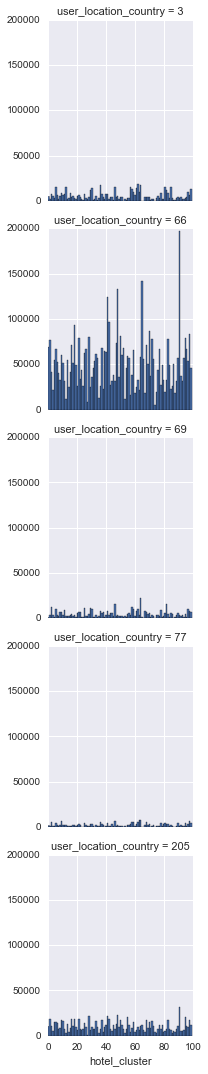

In [10]:
idxs = train['user_location_country'].value_counts().nlargest(5).index
dfpartial = train.loc[train['user_location_country'].isin(idxs)]
p = sns.FacetGrid(dfpartial,
                  row = 'user_location_country')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

Check 'user_location_region' next.

In [11]:
train['user_location_region'].value_counts().size

989

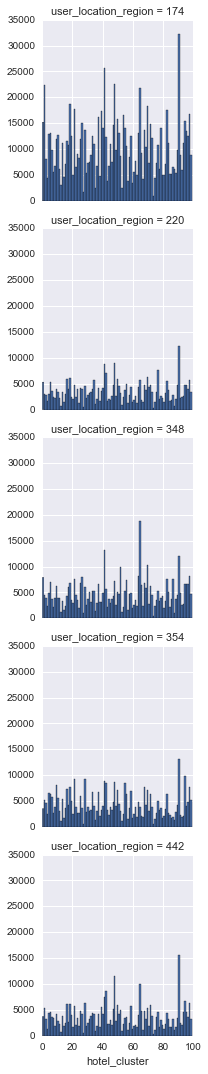

In [12]:
idxs = train['user_location_region'].value_counts().nlargest(5).index
dfpartial = train.loc[train['user_location_region'].isin(idxs)]
p = sns.FacetGrid(dfpartial,
                  row = 'user_location_region')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

I will ignore 'user_location_city' because it is too detailed. Check 'is_mobile' and 'is_package' next.

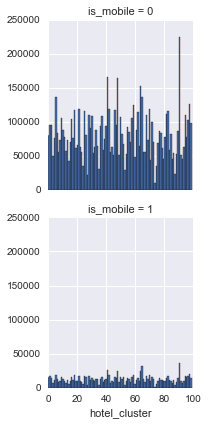

In [13]:
p = sns.FacetGrid(train,
                  row = 'is_mobile')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

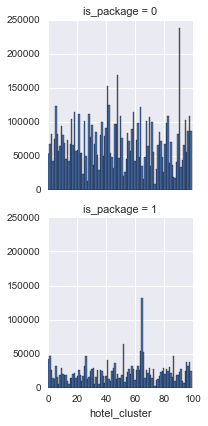

In [14]:
p = sns.FacetGrid(train,
                  row = 'is_package')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

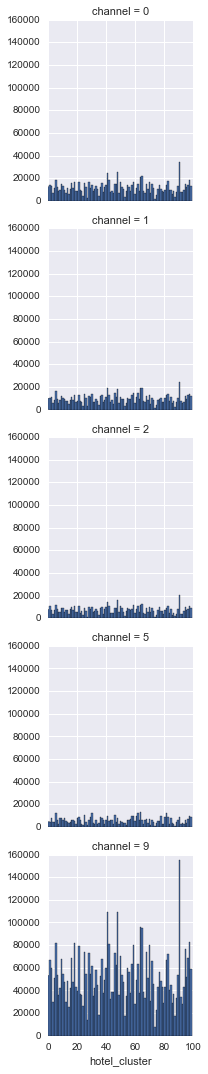

In [15]:
# find the top 5 most popular channel
idxs = train['channel'].value_counts().nlargest(5).index

# subset data from these top 5 channel
dfpartial = train.loc[train['channel'].isin(idxs)]

p = sns.FacetGrid(dfpartial,
                  row = 'channel')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

Next, check 'srch_adults_cnt', 'srch_children_cnt' and 'srch_rm_cnt'

In [16]:
train['srch_adults_cnt'].value_counts().size

10

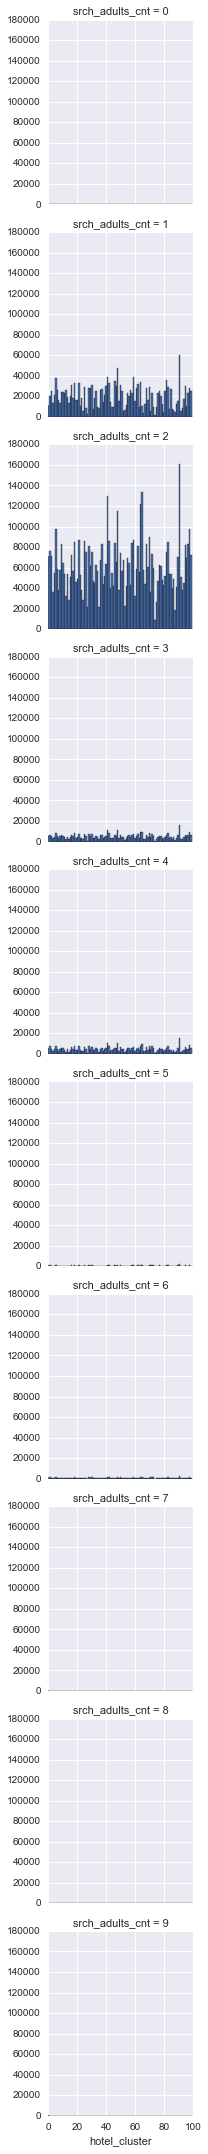

In [17]:
p = sns.FacetGrid(train,
                  row = 'srch_adults_cnt')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

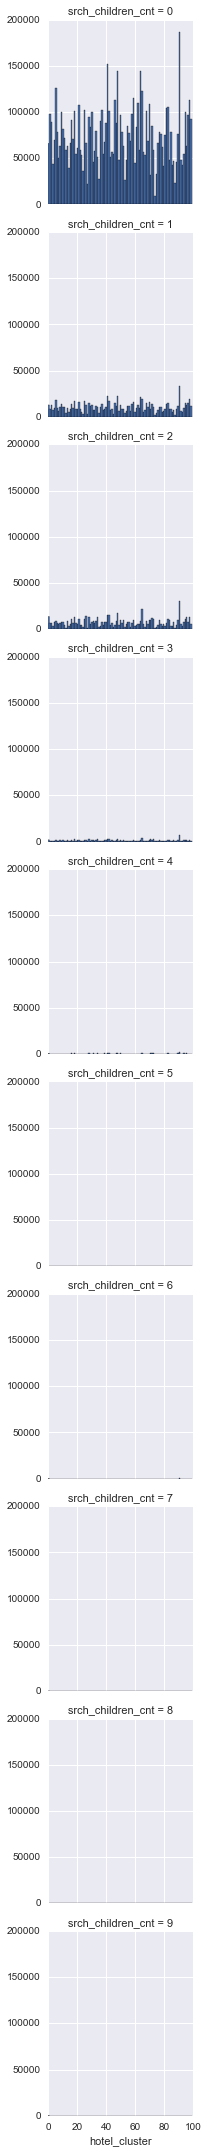

In [18]:
p = sns.FacetGrid(train,
                  row = 'srch_children_cnt')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

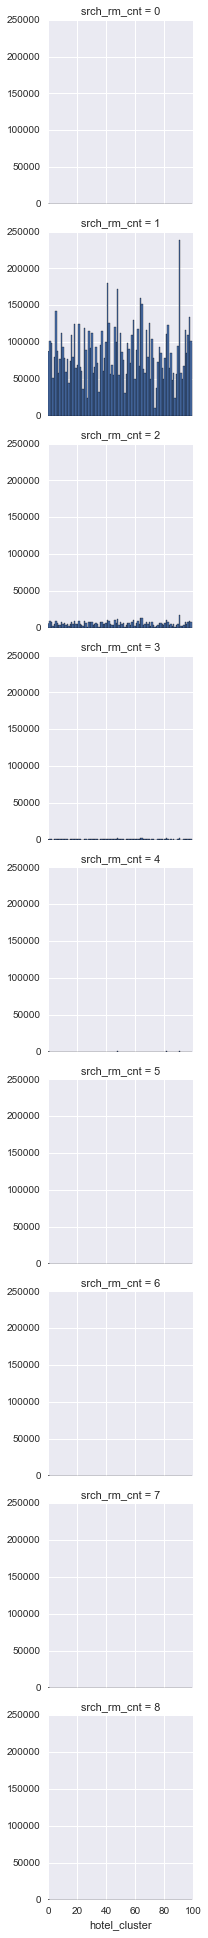

In [19]:
p = sns.FacetGrid(train,
                  row = 'srch_rm_cnt')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

Next, check 'hotel_country' and 'hotel_market'

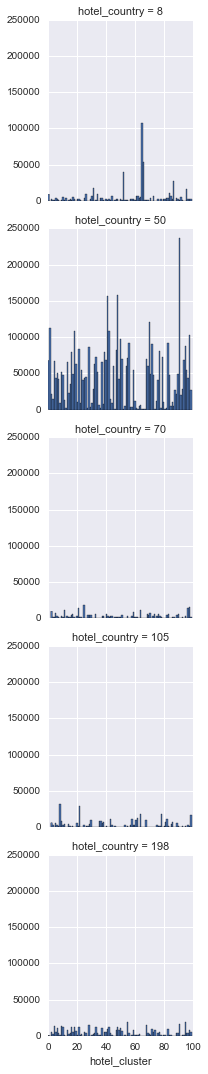

In [20]:
idxs = train['hotel_country'].value_counts().nlargest(5).index
dfpartial = train.loc[train['hotel_country'].isin(idxs)]

p = sns.FacetGrid(dfpartial,
                  row = 'hotel_country')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)

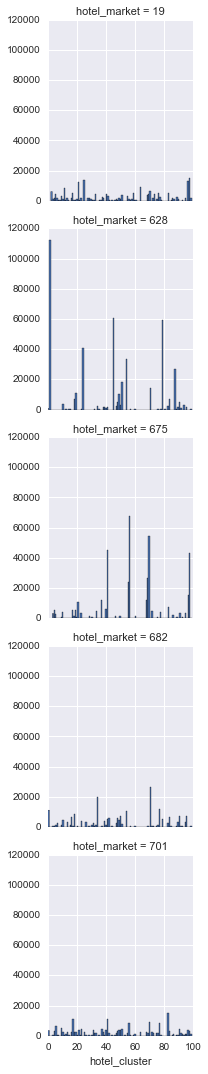

In [21]:
idxs = train['hotel_market'].value_counts().nlargest(5).index
dfpartial = train.loc[train['hotel_market'].isin(idxs)]

p = sns.FacetGrid(dfpartial,
                  row = 'hotel_market')
p = p.map(pyplot.hist, 'hotel_cluster', bins = 100)